In [15]:
#!/usr/bin/env python3
import numpy as np
import MDAnalysis as mda
from scipy.spatial import Delaunay, distance_matrix, Voronoi
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import random

In [16]:
a = 1.42 #latconst

1. scipy distance_matrix
2. 0.7*a_0 to 1.2*a_0
3. find easiest way to generate most disordered

In [17]:
def find_neighbors(positions, cutoff):
    dist_mat = distance_matrix(positions, positions)
    np.fill_diagonal(dist_mat, np.inf)
    mask = dist_mat < cutoff
    neighbor_list = [np.flatnonzero(mask[i]).tolist() for i in range(mask.shape[0])]
    return neighbor_list

In [18]:
def bond_angle(xi, yi, xj, yj):
    dx = xj - xi
    dy = yj - yi
    return np.arctan2(dy,dx)

# --- Helper function: simple ring-finding based on DFS ---
def find_rings(adjacency, max_cycle_size=8):
    """
    Find all simple cycles (rings) in an undirected graph represented by an adjacency list.
    Returns a set of frozensets, each representing a ring (order is disregarded).
    """
    N = len(adjacency)
    found_rings = set()

    def dfs(start, current_path, visited_set):
        if len(current_path) > max_cycle_size:
            return
        current = current_path[-1]
        for nbr in adjacency[current]:
            if nbr == start and len(current_path) >= 3:
                # Found a cycle: sort the path to create a canonical representation
                ring = frozenset(current_path)
                found_rings.add(ring)
            elif nbr not in visited_set:
                dfs(start, current_path + [nbr], visited_set | {nbr})

    for i in range(N):
        dfs(i, [i], {i})
    return found_rings

# --- Helper function: reorder a ring into a cyclic path ---
def reorder_ring(ring_nodes, positions):
    """
    Given a set or list of nodes that form a cycle, return a list of nodes
    ordered such that consecutive nodes are (approximately) neighbors in space.
    A simple greedy approach is used.
    """
    ring_nodes = list(ring_nodes)
    if len(ring_nodes) < 3:
        return ring_nodes
    # Start with the leftmost node
    ring_nodes.sort(key=lambda i: (positions[i, 0], positions[i, 1]))
    ordered = [ring_nodes[0]]
    used = set(ordered)
    while len(ordered) < len(ring_nodes):
        last = ordered[-1]
        # Choose the remaining node closest to the last one.
        next_node = min([i for i in ring_nodes if i not in used],
                        key=lambda i: np.linalg.norm(positions[i]-positions[last]))
        ordered.append(next_node)
        used.add(next_node)
    return ordered

In [19]:
def plot_lattice(positions, random_atom, random_index, neighbor_list, neighbor_indices, zoom, atom_numbers,title="crystal"):
    N = len(positions)
    neighbor_count = np.array([len(nlist) if isinstance(nlist, list) else 1 for nlist in neighbor_list])

    color_array = []
    for i in range(N):
        if neighbor_count[i] == 5:
            color_array.append('red')       # potential pentagon site
        elif neighbor_count[i] == 6:
            color_array.append('gray')      # typical hexagon site
        elif neighbor_count[i] == 7:
            color_array.append('red')       # potential heptagon site
        else:
            color_array.append('lightgray')
    
    edges = []
    for i in range(N):
        neighs = neighbor_list[i] if isinstance(neighbor_list[i], list) else [neighbor_list[i]]
        for j in neighs:
            if j > i:
                edges.append((i, j))
    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_title(title)
    
    pos_x = positions[:, 0]
    pos_y = positions[:, 1]
    ax.scatter(pos_x, pos_y, c=color_array, s=30, label='Atoms')
    
    if zoom == True:
        for (i, j) in edges:
            xi, yi = positions[i]
            xj, yj = positions[j]
            ax.plot([xi, xj], [yi, yj], 'k-', linewidth=0.5, alpha=0.7)
        
        pos_x = positions[:, 0]
        pos_y = positions[:, 1]
        ax.scatter(pos_x, pos_y, c=color_array, s=30, label='Atoms')

        ax.scatter(random_atom[0], random_atom[1], color='red', s=100,
                label=f'Atom {atom_numbers[random_index]} (Chosen)')
        if neighbor_indices:
            ax.scatter(positions[neighbor_indices, 0], positions[neighbor_indices, 1],
                    color='blue', s=60, label='Nearest Neighbors')
        
        ax.text(random_atom[0], random_atom[1], f'{atom_numbers[random_index]}',
                color='red', fontsize=12, ha='right', va='top')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.axis('equal')

    rings = find_rings(neighbor_list, max_cycle_size=8)
    # Loop over each ring
    for ring in rings:
        ring_size = len(ring)
        
        # Reorder ring nodes to make a continuous polygon
        ordered_ring = reorder_ring(ring, positions)
        
        # Choose color: red for 5 and 7, gray for 6.
        if ring_size == 6:
            ring_color = 'green'
        else:
            ring_color = 'red'
        
        # Draw the ring boundary (closed polygon)
        ring_coords = positions[ordered_ring]
        # Append the first coordinate at the end to close the loop
        ring_coords = np.vstack([ring_coords, ring_coords[0]])
        ax.plot(ring_coords[:,0], ring_coords[:,1], '-', color=ring_color, linewidth=2)
    
    # 6) Inset for zoomed-in bond-angle view for the chosen atom and its neighbors.
    inset_size = 0.35
    if zoom == True:
        axins = inset_axes(ax, width=f"{int(inset_size*100)}%", height=f"{int(inset_size*100)}%",
                        loc='upper right', borderpad=2)

        # In the inset, plot the background (all atoms as light gray)
        axins.scatter(pos_x, pos_y, c='black', s=10)
        axins.scatter(random_atom[0], random_atom[1], color='red', s=100)
        axins.scatter(positions[neighbor_indices, 0], positions[neighbor_indices, 1],
                    color='blue', s=60)

        # Draw green dashed lines from the chosen atom to each neighbor in inset
        angles = []
        for j in neighbor_indices:
            xj, yj = positions[j]
            theta = bond_angle(random_atom[0], random_atom[1], xj, yj)
            angles.append(theta)
            
            axins.plot([random_atom[0], xj], [random_atom[1], yj], 'g--', linewidth=1)
            angle_deg = np.degrees(theta)
            mid_x = (random_atom[0] + xj) / 2
            mid_y = (random_atom[1] + yj) / 2
            axins.text(mid_x, mid_y, f"{angle_deg:.1f}°", fontsize=8,
                    color='black', ha='center', va='center')
        
        padding = 2.0
        axins.set_xlim(random_atom[0] - padding, random_atom[0] + padding)
        axins.set_ylim(random_atom[1] - padding, random_atom[1] + padding)
        axins.set_xticks([])
        axins.set_yticks([])
        axins.set_title(r"Director field $\theta_{ij}$", fontsize=12)
    
    plt.show()

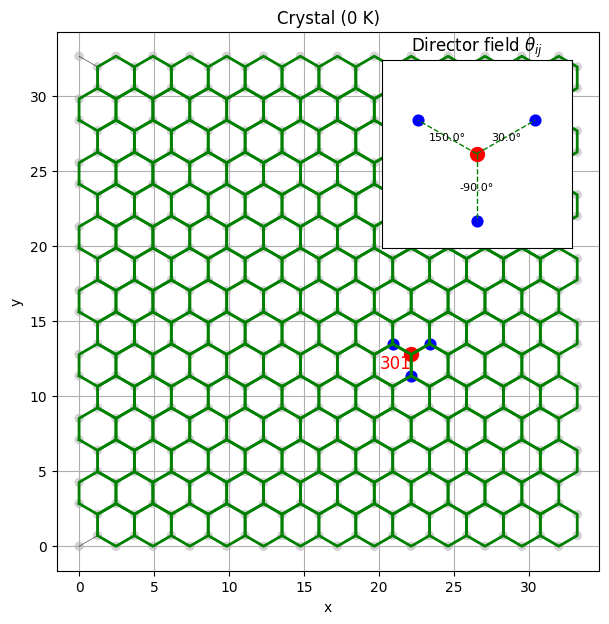

In [21]:
data = np.loadtxt("output/crystal.txt")
atom_numbers = data[:, 0].astype(int)
positions = data[:,2: 4]

cutoff = (a+10E-5)
neighbors = find_neighbors(positions, cutoff)
random_index = 300
random_atom = positions[random_index]
neighbor_indices = neighbors[random_index]

plot_lattice(positions, random_atom, random_index,neighbors, neighbor_indices, True, atom_numbers, title="Crystal (0 K)")

KeyboardInterrupt: 

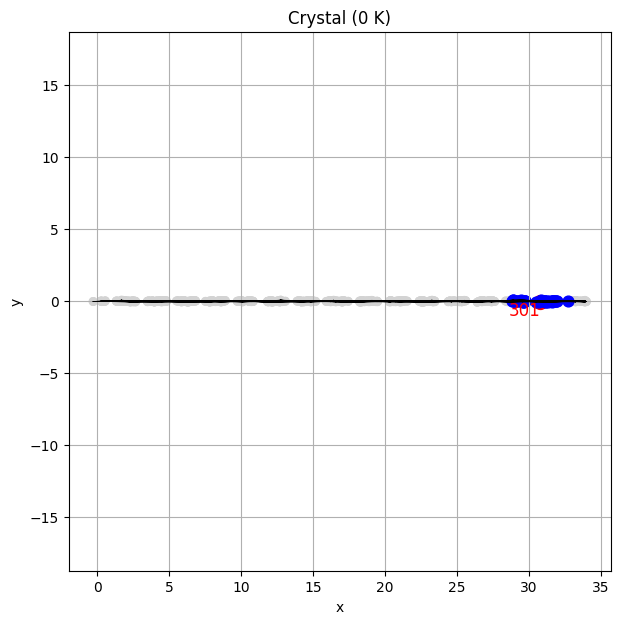

In [137]:
data = np.loadtxt("output/1000K.txt")
atom_numbers = data[:, 0].astype(int)
positions = data[:,2: 4]

cutoff = (a*1.4)
neighbors = find_neighbors(positions, cutoff)
random_index = 300
random_atom = positions[random_index]
neighbor_indices = neighbors[random_index]

plot_lattice(positions, random_atom, random_index,neighbors, neighbor_indices, True, atom_numbers, title="Crystal (0 K)")

In [23]:
import numpy as np

def orientation_order(positions, neighbor_list, m=6):
    N = len(positions)
    sum_of_psi = np.zeros(N, dtype=np.complex128)
    count = np.zeros(N, dtype=int)
    
    for i, nbrs in enumerate(neighbor_list):
        for j in nbrs:
            dx = positions[j, 0] - positions[i, 0]
            dy = positions[j, 1] - positions[i, 1]
            angle = np.arctan2(dy, dx)
            sum_of_psi[i] += np.exp(1j * m * angle)
        count[i] = len(nbrs)
    
    # Avoid division by zero
    psi = np.divide(sum_of_psi, count, out=np.zeros_like(sum_of_psi), where=(count != 0))
    return psi

def G_6(positions, psi, r_bins, m=6):
    N = len(positions)
    dist_mat = distance_matrix(positions, positions)
    i_idx, j_idx = np.triu_indices(N, k=1)
    pair_dists = dist_mat[i_idx, j_idx]
    correl_ij = psi[i_idx] * psi[j_idx].conjugate()
    bin_index = np.digitize(pair_dists, r_bins) - 1
    G_accum = np.zeros(len(r_bins) - 1, dtype=np.complex128)
    counts  = np.zeros(len(r_bins) - 1, dtype=int)
    valid = (bin_index >= 0) & (bin_index < len(r_bins) - 1)
    np.add.at(G_accum,  bin_index[valid], correl_ij[valid])
    np.add.at(counts,   bin_index[valid], 1)

    with np.errstate(divide='ignore', invalid='ignore'):
        G_m = G_accum / counts

    r_mid = 0.5 * (r_bins[:-1] + r_bins[1:])
    return r_mid, G_m

In [24]:
def read_positions_file(filename):
    frames = []
    frame = []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            # Header lines start with '#' (skip them but if there's an accumulated frame, save it)
            if line.startswith("#"):
                if frame:
                    frames.append(np.array(frame))
                    frame = []
                continue
            # Blank lines indicate frame separation too
            if not line:
                if frame:
                    frames.append(np.array(frame))
                    frame = []
                continue
            parts = line.split()
            if len(parts) < 4:
                continue
            # Assuming the written file has: id, x, y, z
            # We read x and y (columns index 1 and 2)
            x = float(parts[1])
            y = float(parts[2])
            frame.append([x, y])
    if frame:
        frames.append(np.array(frame))
    return frames

In [93]:
# Read the positions for 500 plus minus 50 K:
filename = "output/positions_1000_K.txt"
frames = read_positions_file(filename)

cutoff = a+10E-3
r_bins = np.linspace(0, 30/a, 30) 

G6_all = []
for pos in frames:
    neighbor_list = find_neighbors(pos, cutoff)
    psi = orientation_order(pos, neighbor_list, m=6)
    r_mid, G6_vals = G_6(pos, psi, r_bins, m=6)
    G6_all.append(G6_vals)

G6_all = np.array(G6_all)
G6_avg = np.mean(G6_all, axis=0)


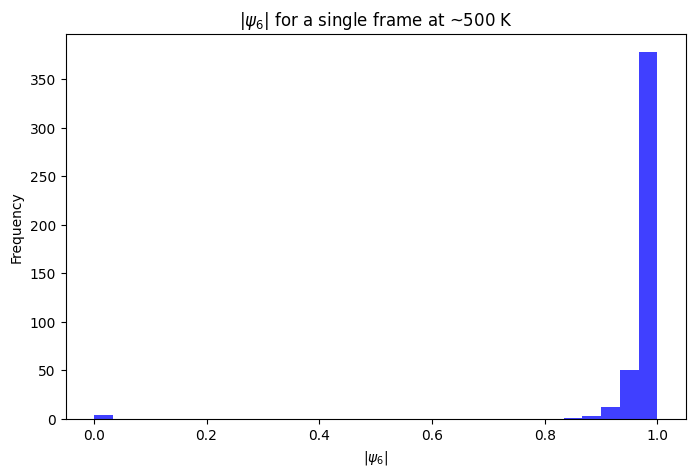

In [99]:
a = 1.42
filename = "output/positions_1000_K.txt"
frames = read_positions_file(filename)
frame = frames[0]
cutoff = a+10e-3
neighbor_list = find_neighbors(frame, cutoff)
psi = orientation_order(frame, neighbor_list, m=6)
psi_abs = np.abs(psi)
plt.figure(figsize=(8, 5))
plt.hist(psi_abs, bins=30, alpha=0.75, color='blue')
plt.xlabel(r'$|\psi_6|$')
plt.ylabel('Frequency')
plt.title(r'$|\psi_6|$ for a single frame at ~500 K')
plt.show()


C:\Users\David\AppData\Local\Temp\ipykernel_2436\3947855756.py:17: RuntimeWarning: Mean of empty slice
  return r_mid, np.nanmean(G6_all, axis=0)


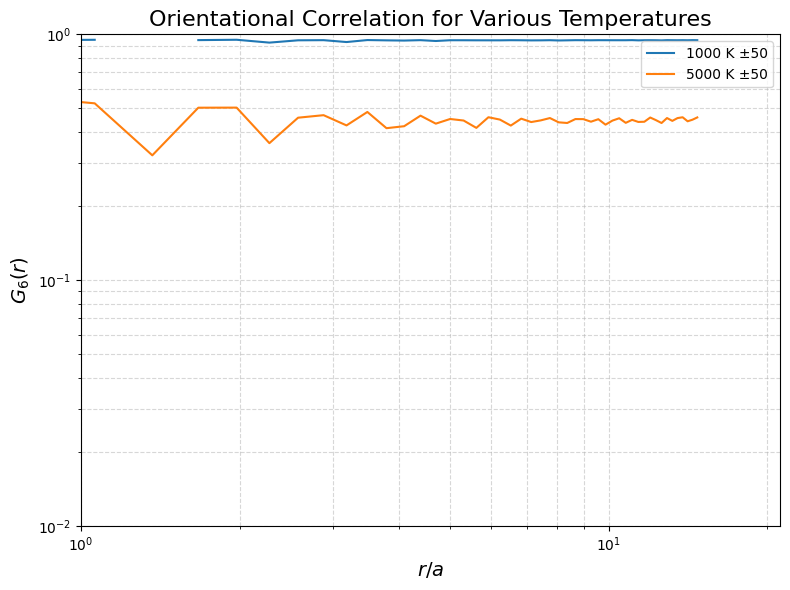

In [133]:
from scipy.ndimage import gaussian_filter1d

# ---- Helper function ----
def compute_average_G6(filename, cutoff, r_bins, m=6):
    """
    Read a LAMMPS dump of positions, compute ψ₆ and G₆(r) for each frame,
    and return r_mid, <G₆(r)> averaged over frames.
    """
    frames = read_positions_file(filename)          # your parser
    G6_list = []
    for pos in frames:
        nbrs = find_neighbors(pos, cutoff)          # your neighbor finder
        psi  = orientation_order(pos, nbrs, m=m)    # your ψ₆ code
        r_mid, G6 = G_6(pos, psi, r_bins, m=m)       # your G₆ code
        G6_list.append(G6)
    G6_all = np.array(G6_list)
    return r_mid, np.nanmean(G6_all, axis=0)

# ---- Parameters ----
a = 1.42  # lattice constant
r_bins = np.linspace(0, 30/a, 50)  # distance bins

# List your datasets here:
datasets = [
    {"filename": "output/positions_1000_K.txt",  "label": "1000 K ±50", "cutoff": 1.4 * a},
    {"filename": "output/positions_10000_K.txt",  "label": "5000 K ±50", "cutoff": 1.4 * a},
]

# ---- Plotting ----
plt.figure(figsize=(8,6))
for data in datasets:
    r_mid, G6_avg = compute_average_G6(data["filename"],
                                       data["cutoff"],
                                       r_bins)
    # smooth the real part
    G6_smooth = gaussian_filter1d(G6_avg.real, sigma=0.01)
    plt.loglog(r_mid/a, G6_smooth, label=data["label"])

plt.xlabel(r'$r/a$', fontsize=14)
plt.ylabel(r'$G_6(r)$', fontsize=14)
plt.title('Orientational Correlation for Various Temperatures', fontsize=16)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.xlim(1, 30/a)
plt.ylim(1e-2, 1)
plt.tight_layout()
plt.show()

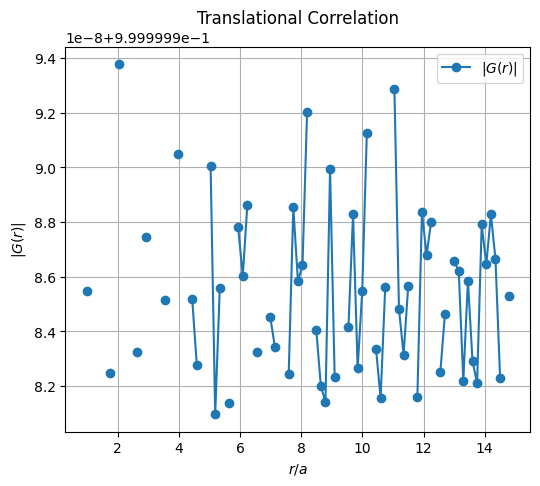

In [149]:
G_mag = 4*np.pi/(np.sqrt(3)*a)
G_vec = np.array([G_mag, 0.0])

def translational_correlation(positions, G_vec, r_bins):
    """
    Compute G_G(r) = < exp(i G·r_i) exp(-i G·r_j) > as a function of |r_i-r_j|.
    positions : (N,2) array of x,y coordinates
    G_vec     : (2,) reciprocal‐lattice vector
    r_bins    : 1D array of bin edges for distances
    returns   : (r_mid, G_G) where G_G is complex‐valued of length len(r_bins)-1
    """
    N = len(positions)
    # 1) compute the phase at each atom
    phases = np.exp(1j * positions.dot(G_vec))

    # 2) get all pairwise distances and pairwise products
    dist_mat = distance_matrix(positions, positions)
    iidx, jidx = np.triu_indices(N, k=1)
    dists = dist_mat[iidx, jidx]
    prods = phases[iidx] * np.conjugate(phases[jidx])

    # 3) bin & average
    bin_idx = np.digitize(dists, r_bins) - 1
    G_accum = np.zeros(len(r_bins)-1, dtype=np.complex128)
    counts  = np.zeros(len(r_bins)-1, dtype=int)
    valid = (bin_idx >= 0) & (bin_idx < len(r_bins)-1)
    np.add.at(G_accum, bin_idx[valid], prods[valid])
    np.add.at(counts,  bin_idx[valid], 1)
    # normalize
    with np.errstate(divide='ignore', invalid='ignore'):
        G_G = G_accum / counts

    # bin centers
    r_mid = 0.5*(r_bins[:-1] + r_bins[1:])
    return r_mid, G_G

r_bins = np.linspace(0, 30/a, 100)

G_mag = 4*np.pi/(np.sqrt(3)*a)
G_x   = np.array([G_mag, 0.0])      # one of the primary RLVs

data = np.loadtxt("output/crystal.txt")
atom_numbers = data[:, 0].astype(int)
positions = data[:,2: 4]

# 4) compute
r_mid, GGr = translational_correlation(positions, G_x, r_bins)
# 5) plot
plt.figure(figsize=(6,5))
plt.plot(r_mid/a, np.abs(GGr), '-o', label=r'$|G(r)|$')
plt.xlabel(r'$r/a$')
plt.ylabel(r'$|G(r)|$')

plt.title("Translational Correlation")
plt.grid(True)
plt.legend()
plt.show()